# Eliminar astigmatismo del espejo



El SLM tiene una superficie que no es perfecta, sino que tiene un poco de curvatura. Esto puede afectar a los resultados de la propagación, principalmente cuando se focalizan haces. 

En este procedimiento se busca cómo detectar y eliminar el astigmatismo

by: Luis Miguel Sánchez Brea

fecha: 28 de mayo de 2021

## Cargar Módulos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY

from py_lab.camera import Camera
from py_lab.motor_linear import Motor
from py_lab.slm import SLM
from py_lab.utils import List_COM_Ports
from numpy import pi

import time
import cv2
import serial
import serial.tools.list_ports
import screeninfo
import matplotlib
from pprint import pprint

# Camara
ms=1.
seconds=1000*ms

# Motores
s = 1

%matplotlib qt
%matplotlib inline

number of processors: 4
total memory        : 6.0 Gb
available memory    : 53 %
max frequency       : 2794 GHz


## Medir el foco de una lente para verificar

1. Se carga una lente 
1. Se mueve la cámara hasta la posición focal
1. Se muestra el foco de la lente

## Modificar la fase capturada

1. Determinar la modulación aberrante del espejo
1. Cargar una máscara de fase con la aberración
1. Incluir la aberración en la imagen
1. Verificar que el foco ha mejorado

In [ ]:
f1_mirror = 4583 * mm
f2_mirror = 11694 * mm
theta_mirror = 108 * degrees
t_mirror = Scalar_mask_XY(x0_slm, y0_slm, wavelength)
t_mirror.elliptical_phase(f1=f1_mirror, f2=f2_mirror, angle=theta_mirror)

In [ ]:
def remove_astimagtism(self, mask_XY):

        fase_mirror = np.angle(t_mirror.u)
        fase_modulator = np.angle(mask_XY.u)
        new_fase = np.exp(1j * (fase_mirror + fase_modulator))
        return fase_mirror + fase_modulator

   

In [ ]:
def condition_image(self, normalize=False):
    """'False', 'complete', '255', 'max'"""
    if normalize is True:
        self.image_raw = (255 * self.image_raw).astype(np.uint8)
    else:
        self.image_raw = (self.image_raw).astype(np.uint8)

## Para sacar

In [3]:
# Cámara
cam = Camera(name="ImagingSource") 
devices = cam.List_Devices(verbose=True)
cam.Open()
cam.Set_Property("Resolution", "Y800 (1024x768)")
# Framerate
cam.Set_Property("FrameRate", 5)
# Otros parametros
cam.Set_Property("Gain", 0, is_switcher=True)
cam.Set_Property("Gain", 2)
#Aquí podemos variar el tiempo de exposición de la cámara. 
value=int(np.log2(1/2000.))
print(value)
cam.Set_Property("Exposure", value)
cam.Start_Live() 


0 : b'DMx 72BUC02 14210296'



-10



In [15]:
cam.Set_Property("Exposure", -7)


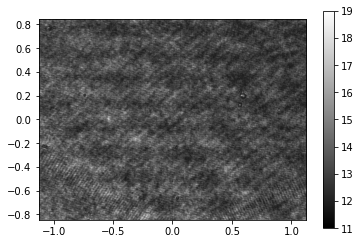

In [4]:
# Comprobamos que se obtiene una imagen. 
image = cam.Get_Image(draw=True)

Ahora toca manejar el motor: 

In [5]:
motor = Motor(name='SMC100')
motor.Open(port='COM3')
motor.Test_Connection()
#El Home es una función inicial para despazar el motor a un punto concreto fijo, el 0 de su sistema. 
motor.Home()

Connecting to SMC100 on COM3
Found stage ILS250PP_PN:B0921669954252_UD:091029
Stage ready


Por último. queda el uso del modulador: 

In [6]:
slm = SLM(name="HoloEye2500", M=0.788)

# Segundo paso: creación de una imagen a partir de una máscara. 
A continuación, obtenemos una imagen a partir de una máscara. Como ejemplo, usamos un sistema de ajedrezado en dos dimensiones. 

Si no se observa una imagen en la pantalla, se debe a que el haz del láser no está incidiendo sobre la cámara. Solución: hay que desplazar vertical y horizontalmente la cámara hasta que se observe la imagen. 

La imagen se puede observar en una ventana que Python crea con la imagen de la cámara en tiempo real.

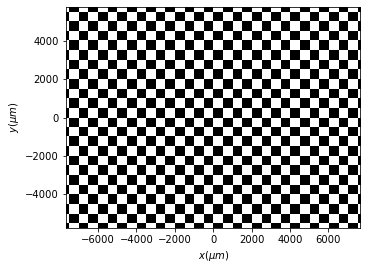

In [8]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.grating_2D_chess(period=1000.0 * um, amin=0, amax=1., phase=0. * pi / 2, r0=[0,0], fill_factor=0.5, angle=0.0 * degrees)
mask.draw(kind='intensity')
slm.Send_Image(mask, norm=1, kind='intensity')

# Tercer paso: movimiento del motor
Con la imagen obtenida, se realiza un desplazamiento constante de la cámara generado por el motor. Como se decía previamente, si la imagen (que se puede observar en una ventana que crea Python con la imagen en tiempo real) se desplaza a medida que se desplaza la cámara, el sistema no está alineado, y entonces: 

- Hay que comprobar que el sistema de lentes que amplía la imagen está correctamente situado. 
- Hay que desplazar un tornillo del divisor del haz láser, debido a que está ligeramente desviado de su correcta posición. 

Una vez se vaya moviendo el motor y desplazando el tornillo, en cuanto se deje de ver movimiento de la imagen, el sistema estará alineado. 

In [9]:
#Para mover el motor, fijamos una velocidad y una posición absoluta, entre -125 Y 125 ("pos"). 
motor.Set_Velocity(vel=10, units='mm/s')

10.0

In [10]:
z0_motor=113.87

In [17]:
motor.Set_Velocity(vel=5, units='mm/s')
motor.Move_Absolute(pos=z0_motor,units='mm', verbose=True, move_time=None)


113.87

# Cuarto paso: centrar la imagen
Una vez el sistema esté alineado, se cambia la imagen del ajedrezado por la imagen generada por un agujero o disco. De esta manera, se generan círculos en vez de un tablero de ajedrez. Con esta imagen, se puede desplazar la cámara horizontal y verticalmente hasta que el centro de las circunferencias de la imagen esté en el centro de la cámara. 

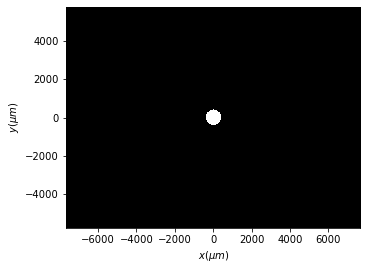

In [16]:
mask.circle(r0=(0,0), radius=400, angle=0)
mask.draw(kind='intensity')
slm.Send_Image(mask, norm=1, kind='intensity')

# Sistema centrado y alineado
Cuando se hayan seguido todos los pasos, entonces se puede afirmar que el sistema está alineado y centrado. 
Se añaden a continuación código de programación para cerrar la cámara, el motor y el modulador. 

In [11]:
slm.Close_All_Images()
motor.Close()
cam.Stop_Live()